In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [91]:
datapath = r"/Users/gkoolstra/Desktop/nwa_scan_cool_down.h5"
savepath = r"/Volumes/slab/_Data/170221 - EonHe M018V4/data/170223/180959_nwa_scan_cool_down"
save = True

temperature = list()

with h5py.File(datapath, "r") as f:
    temperature = f["temperature"][()]
    fpoints = f["fpoints"][()]
    mags = f["mags"][()]
print("Loaded File #1")

Loaded File #1


In [71]:
Qs = list()
f0s = list()

start_index = 1250

use_asymmetric_fit = False

#fig = plt.figure(figsize=(5.,3.))
#common.configure_axes(12)

for idx in tqdm(range(start_index, np.shape(mags)[0])):
    xdata = np.array(fpoints[0,:], dtype=np.float64)
    ydata = common.dBm_to_W(np.array(mags[idx,:], dtype=np.float64))
    
    #plt.plot(xdata, ydata, color='blueviolet', alpha=0.5)
    #plt.yscale('log')

    if use_asymmetric_fit:
        fitguess = [np.max(ydata), fpoints[0,np.argmax(mags[idx,:])], 1E6/2., 0.05]
        fr, ferr = kfit.fit_lor_asym(xdata, ydata, fitparams=fitguess, 
                                     parambounds=[(-np.inf, -np.inf, 0, -np.inf),(+np.inf, +np.inf, +np.inf, +np.inf)], 
                                     verbose=False)
        #plt.plot(xdata, kfit.asym_lorfunc(xdata, *fr), '-k')
        f0s.append(fr[-3])
        Qs.append(fr[-3]/(fr[-2]))
    else:
        fitguess = [1E-5, fpoints[0,np.argmax(mags[idx,:])], 1E6/2.]
        fr, ferr = kfit.fit_lor(xdata, ydata, fitparams=fitguess, no_offset=True, 
                                parambounds=[(-np.inf, -np.inf, 0),(+np.inf, +np.inf, +np.inf)], 
                                verbose=False)
        #plt.plot(xdata, kfit.lorfunc(xdata, *fr), '-k')
        f0s.append(fr[-2])
        Qs.append(fr[-2]/(2*fr[-1]))
    
    
    #plt.xlim(np.min(fpoints/1E9), np.max(fpoints/1e9))
    #plt.ylim(1E-11, 2E-8)
    

    #print("QL = %d"%(fr[-3]/(2*fr[-2])))

f0s = np.array(f0s)
Qs = np.array(Qs)

100%|██████████| 9839/9839 [00:27<00:00, 352.86it/s]


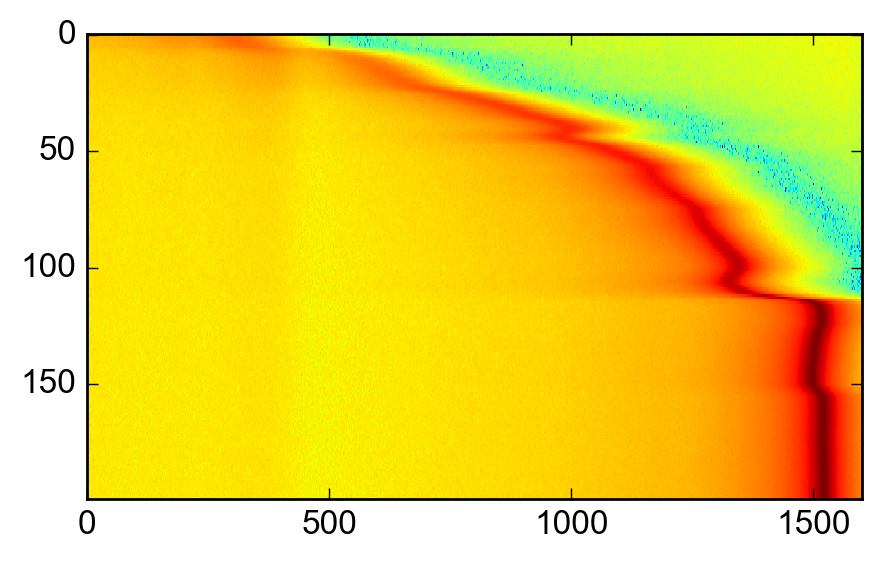

In [87]:
start_index = 1250
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.imshow(mags[start_index:start_index+200,:], aspect='auto', interpolation='none')

===========================  ====================  =====================
Parameter                           Value                   Std
===========================  ====================  =====================
f0                            5.393564444659541    0.002181581581896341
Kinetic Inductance fraction  0.028636188953495754  0.0008305752452205981
Tc                            6.305233451816731    0.024503517470373486
===========================  ====================  =====================


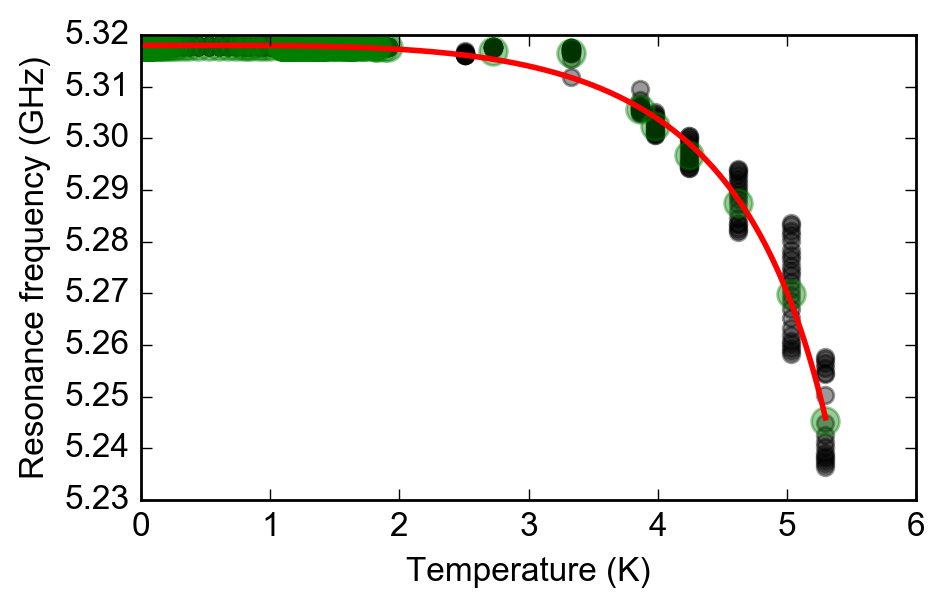

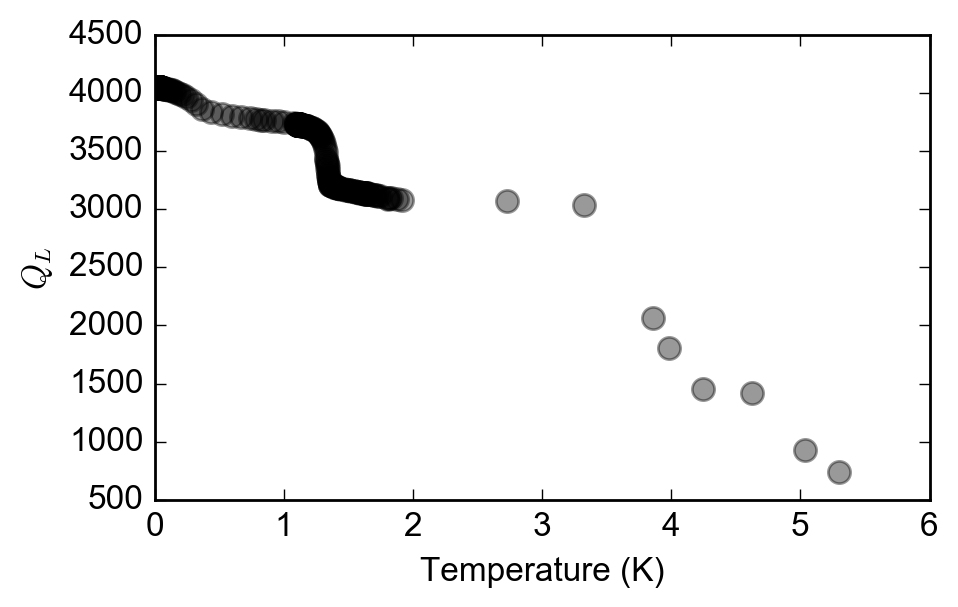

In [93]:
fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(temperature[start_index:], f0s/1E9, 'o', **common.plot_opt('black', msize=6))

temp_change_idx = np.append(np.array([0]),np.where(np.diff(temperature[start_index:]) < 0)[0])
temps_fit = temperature[start_index+temp_change_idx[1:]]
f0s_fit = list()
Qs_fit = list()

for t in range(len(temp_change_idx)-1):
    f0s_fit.append(np.mean(f0s[temp_change_idx[t]:temp_change_idx[t+1]]))
    Qs_fit.append(np.mean(Qs[temp_change_idx[t]:temp_change_idx[t+1]]))
    
plt.plot(temps_fit, np.array(f0s_fit)/1e9, 'o', **common.plot_opt('green', msize=10))


f0_guess = 5.45
alpha_guess = 0.05
Tc_guess = 7

temps_plot = np.linspace(np.min(temperature[start_index:]), np.max(temperature[start_index:]), 1E4)

fr, ferr = kfit.fit_kinetic_fraction(temps_fit, np.array(f0s_fit)/1E9, fitparams=[f0_guess, alpha_guess, Tc_guess], 
                                     showfit=False, parambounds=[[0.0, 0.0, 0.0], [np.inf, np.inf, np.inf]])

#plt.plot(temps_plot, kfit.kinfunc(temps_plot, *[f0_guess, alpha_guess, Tc_guess]))
plt.plot(temps_plot, kfit.kinfunc(temps_plot, *fr), '-r', lw=2.0)
plt.xlabel("Temperature (K)")
plt.ylabel("Resonance frequency (GHz)")

if save: 
    common.save_figure(fig, save_path=savepath)

fig2 = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(temps_fit, Qs_fit, 'o', **common.plot_opt('black'))
plt.xlabel("Temperature (K)")
plt.ylabel("$Q_L$")

if save: 
    common.save_figure(fig2, save_path=savepath)
